<a href="https://colab.research.google.com/github/ymuto0302/base2_2020/blob/master/GIS5_WDI_education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地理情報の活用：SDGs と地理情報
SDGs では貧困，教育，平等性，気候変動等，様々な問題が取り上げられている。

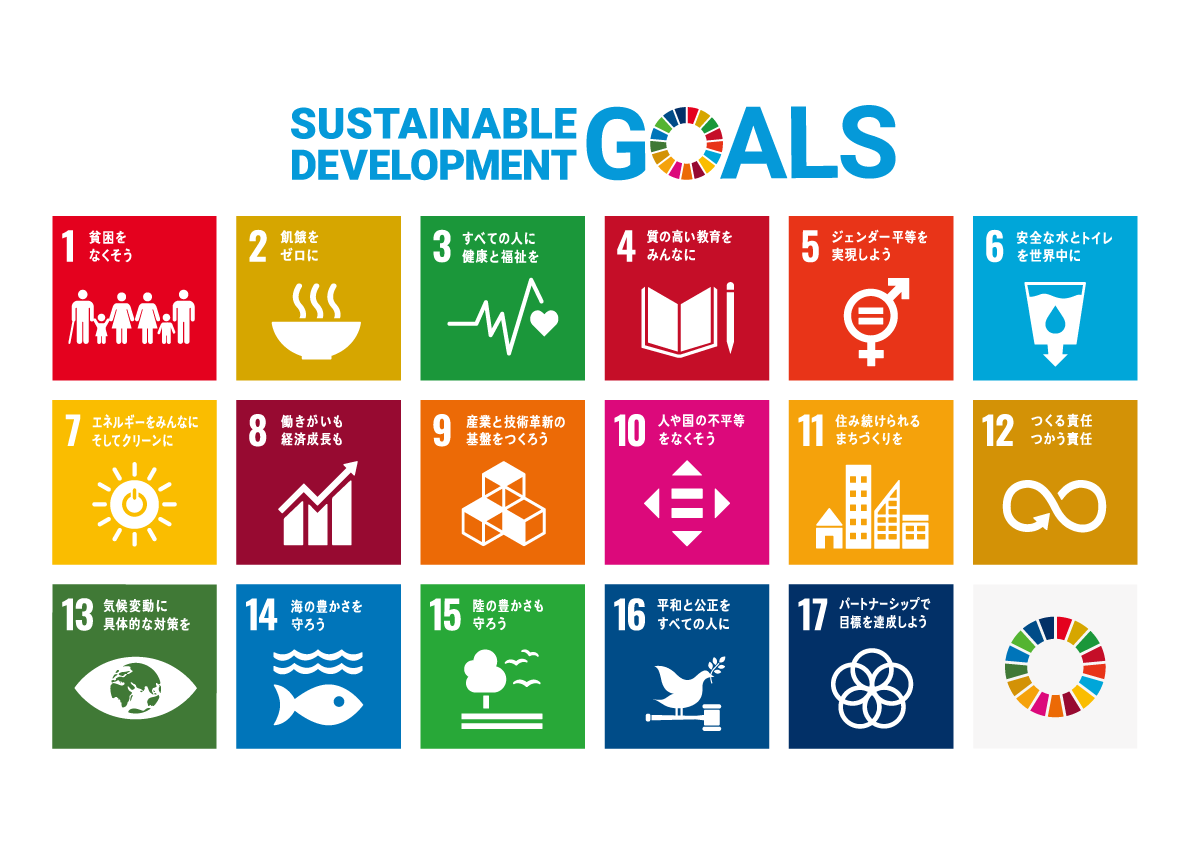

### 前回の授業
"World Development Indicators" データセットを利用し，アフリカ諸国における access to electorcity / improved water 等を地理データ上に展開した。

### 今回の授業
前回に引き続き，利用するデータセットは "World Development Indicators" である。
今回は「教育」に焦点を当て，

- 就学率 (enrollment ratio)
- gender parity index (GPI)

の観点から各国の状況を可視化する。

例によって "World Development Indicators" の URL は以下のとおり：

https://datacatalog.worldbank.org/dataset/world-development-indicators

## (準備) Google Drive のマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## (準備) GeoPandas のインストール

In [14]:
!pip install geopandas

     |████████████████████████████████| 972kB 10.6MB/s 
     |████████████████████████████████| 14.8MB 335kB/s 
     |████████████████████████████████| 6.5MB 50.3MB/s 


## (ウォーミングアップ) アジアにおける "access to electrocity"
前週に取り上げた "access to electrocity" を **アジア** で見てみよう。

### World Development Indicators のデータを全て読み込む

In [11]:
import pandas as pd
indicators = pd.read_csv("/content/drive/My Drive/BASE2/GeoData/WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
world_data = indicators[indicators['IndicatorCode'] == 'EG.ELC.ACCS.ZS']

# 2012年のデータのみに絞り込む
world_data = world_data[world_data['Year'] == 2012]

### アジアのみを取り出す
Wikipedia 上の国名コードの一覧 ( https://ja.wikipedia.org/wiki/ISO_3166-1 )から
アジアに分類される国名・国コードを抽出し，ファイル Asia.csv に格納した。

In [7]:
# アジアに分類される国の情報を取得
asia = pd.read_csv('/content/drive/My Drive/BASE2/GeoData/Asia.csv')

In [8]:
asia.head()

,国・地域名,ISO 3166-1における英語名,numeric,alpha-3,alpha-2,場所,各行政区分
0,ウズベキスタン,Uzbekistan,860,UZB,UZ,中央アジア,ISO 3166-2:UZ
1,カザフスタン,Kazakhstan,398,KAZ,KZ,中央アジア,ISO 3166-2:KZ
2,キルギス,Kyrgyzstan,417,KGZ,KG,中央アジア,ISO 3166-2:KG
3,タジキスタン,Tajikistan,762,TJK,TJ,中央アジア,ISO 3166-2:TJ
4,トルクメニスタン,Turkmenistan,795,TKM,TM,中央アジア,ISO 3166-2:TM


In [12]:
# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
# (注意) 前回より，この部分のコードを変更した
asia_data = world_data.copy() # データのコピー
asia_data = asia_data[world_data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

(注意) アジア諸国に絞り込む際のコードが前回と異なる。(pandas オススメの書き方に変更した)

#### (メモ) .loc を利用した値の修正について
データの絞り込みについて，多くのサイトに下記のコードが掲載されているが，pandas は warning を発する。

`world_data[world_data['CountryCode'].isin(asia_iso_a3)]`

詳細は下記の Web ページを参照すること：

https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

### 世界地図とのマージ ＆ 可視化

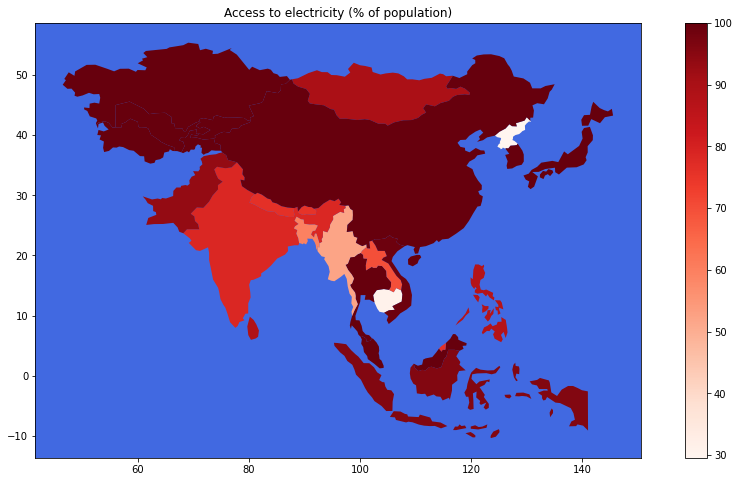

In [15]:
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
asia_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(asia_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_title("Access to electricity (% of population)")
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる


### 考察
北朝鮮(Korea, Dem. Rep.) とカンボジア(Cambodia)の数値が極めて低いようだ。

これらの値を見てみよう。

In [16]:
asia_data[asia_data['CountryName'].str.contains('Korea')]

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5296926,"Korea, Dem. Rep.",PRK,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,29.56256
5297166,"Korea, Rep.",KOR,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,100.00000


In [17]:
asia_data[asia_data['CountryName']=='Cambodia']

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5247499,Cambodia,KHM,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,31.1


# ここから本番！

各国の "就学率" および "gender parity index" を取り上げる。

## (テーマ1) 就学率
一般に学校教育は
- primary  education: 初等教育（小学校）
- secondary education: 中等教育（中学校・高等学校）
- tertiary education: 高等教育（大学・大学院）

の３段階に分けられる。もちろん国によって初等教育や中等教育の年限は多少，異なるが，
本授業では細かい点に留意しない。

### 初等教育における就学率
以下ではアジア各国の「初等教育における就学率」を見てみよう。

初等教育における就学率 (Gross enrolment ratio, primary, both sexes (%))の
indicator code は "SE.PRM.ENRR" である。


In [19]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("/content/drive/My Drive/BASE2/GeoData/WorldDevelopmentIndicators/Indicators.csv")

# Gross enrolment ratio, primary, both sexes (%) を取り出す
world_data = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']

# 2012年のデータのみに絞り込む
world_data = world_data[world_data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('/content/drive/My Drive/BASE2/GeoData/Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = world_data.copy() # データのコピー
asia_data = asia_data[world_data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

In [20]:
asia_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5239018,Bhutan,BTN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,112.331871
5243663,Brunei Darussalam,BRN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,95.458504
5247871,Cambodia,KHM,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,124.175407
5252906,China,CHN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,127.852051
5284691,"Hong Kong SAR, China",HKG,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,101.160431


一般に ""gross enrolment ratio (GER)" は 100% を超える。

分かりやすい説明が unesco.org に掲載されているから，参照してください。

http://uis.unesco.org/en/glossary-term/gross-enrolment-ratio#:~:text=A%20GER%20value%20approaching%20or,indicate%20the%20proportion%20already%20enrolled.

そこで 100% を超えるケースについては，全て 100% とみなして処理を進めていこう。

**(注) gross でなく adjusted net の値も存在するが，国によって集計年度が異なるため，コードがややこしくなる。故に，本授業では（誤差が含まれるものの，傾向を掴むには問題ないとみなし）gross の値を用いる。**

In [21]:
# 就学率は 100% を超えるものだ，という前提に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

In [22]:
extracted_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5239018,Bhutan,BTN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000
5243663,Brunei Darussalam,BRN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,95.458504
5247871,Cambodia,KHM,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000
5252906,China,CHN,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000
5284691,"Hong Kong SAR, China",HKG,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,100.000000


最後に可視化する

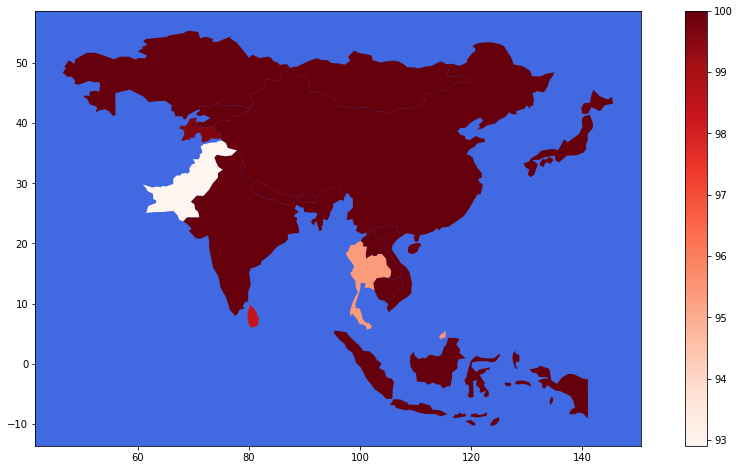

In [23]:
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### 考察
殆どの国で 100% の就学率を達成している。
パキスタンが最低といっても 93% 近い。ミャンマー，スリランカがやや低めである。

In [24]:
extracted_data[extracted_data['CountryName']=='Pakistan']

,CountryName,iso_a3,IndicatorName,IndicatorCode,Year,Value
5329552,Pakistan,PAK,"Gross enrolment ratio, primary, both sexes (%)",SE.PRM.ENRR,2012,92.902702


### ここまでをまとめたコード

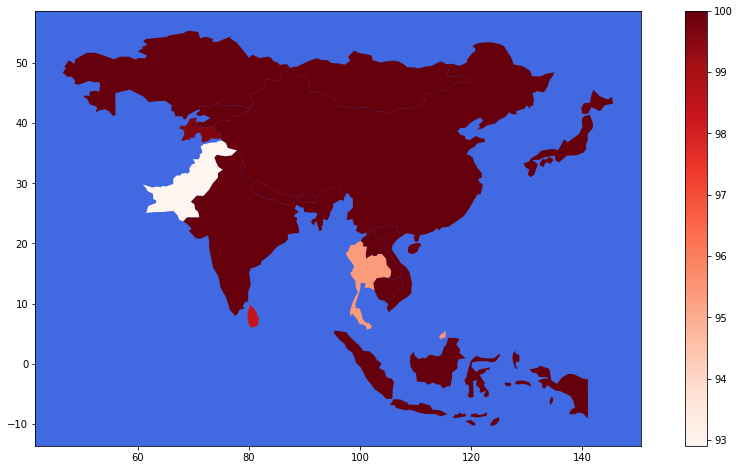

In [25]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("/content/drive/My Drive/BASE2/GeoData/WorldDevelopmentIndicators/Indicators.csv")

# Gross enrolment ratio, primary, both sexes (%) を取り出す
world_data = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']

# 2012年のデータのみに絞り込む
world_data = world_data[world_data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('/content/drive/My Drive/BASE2/GeoData/Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = world_data.copy() # データのコピー
asia_data = asia_data[world_data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### 同じ要領で中等教育での就学率(SE.SEC.ENRR: Gross enrolment ratio, secondary, both sexes (%) )を見てみよう

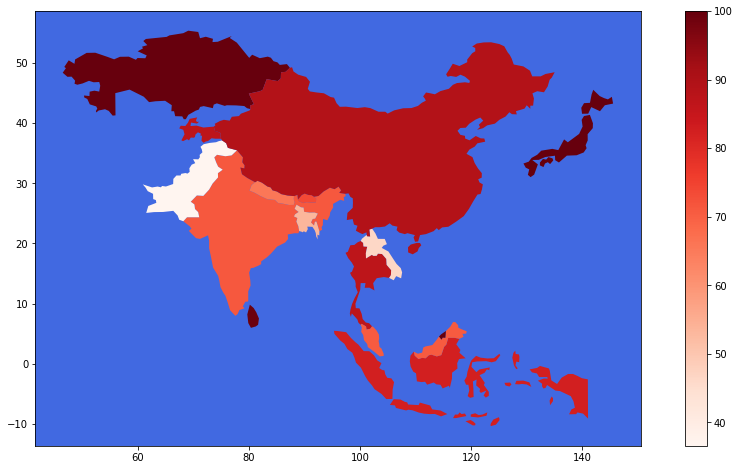

In [26]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("/content/drive/My Drive/BASE2/GeoData/WorldDevelopmentIndicators/Indicators.csv")

# Gross enrolment ratio, secondary, both sexes (%) を取り出す
world_data = indicators[indicators['IndicatorCode'] == 'SE.SEC.ENRR']

# 2012年のデータのみに絞り込む
world_data = world_data[world_data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('/content/drive/My Drive/BASE2/GeoData/Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = world_data.copy() # データのコピー
asia_data = asia_data[world_data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### 同じ要領で高等教育での就学率(SE.TER.ENRR: Gross enrolment ratio, tertiary, both sexes (%) )を見てみよう

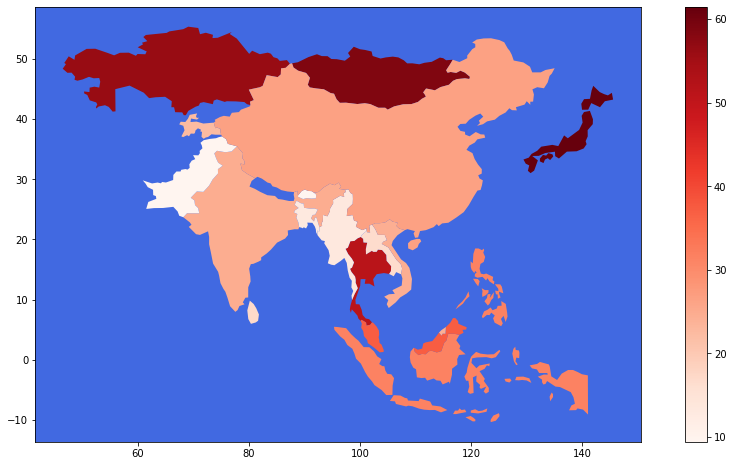

In [27]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("/content/drive/My Drive/BASE2/GeoData/WorldDevelopmentIndicators/Indicators.csv")

# Gross enrolment ratio, tertiary, both sexes (%) を取り出す
world_data = indicators[indicators['IndicatorCode'] == 'SE.TER.ENRR']

# 2012年のデータのみに絞り込む
world_data = world_data[world_data['Year'] == 2012]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('/content/drive/My Drive/BASE2/GeoData/Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = world_data.copy() # データのコピー
asia_data = asia_data[world_data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
extracted_data = asia_data.copy() # データフレームのコピー
mask = asia_data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(extracted_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)
# wv.plot(column='Value', cmap='Paired', legend=True # こっちで色を塗ると，値のない領域が明確になる

### 初等・中等・高等教育における就学率の比較
上記のコードの一部をまとめ，初等(primary), 中等(secondary)，高等(tertiary)それぞれの就学率を比較する。

ただし，**３つの図においてスケールが異なる点に注意が必要**である。

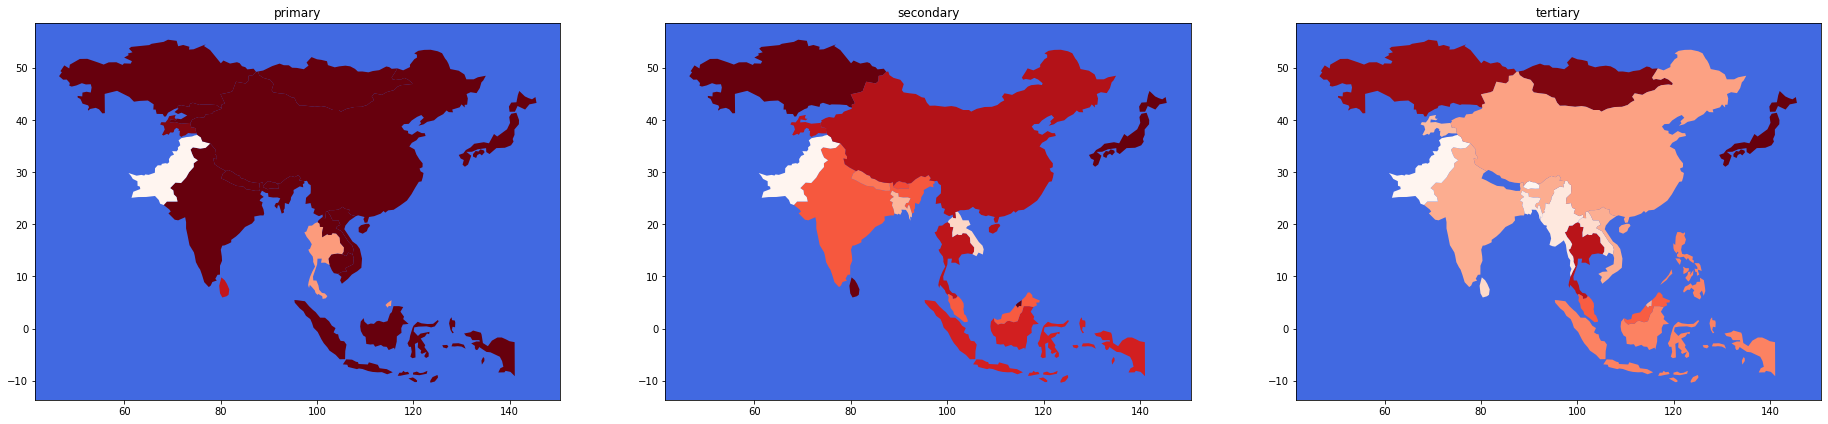

In [28]:
import pandas as pd

def extract(data, country_iso_a3, year=2012):
    data = data[data['Year'] == year]
    data = data[data['CountryCode'].isin(country_iso_a3)]

    # 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
    extracted_data = data.copy() # データフレームのコピー
    mask = data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
    extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

    # 後のマージのため，列名 CountryCode を iso_a3 へリネーム
    extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

    return extracted_data

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("/content/drive/My Drive/BASE2/GeoData/WorldDevelopmentIndicators/Indicators.csv")

# 初等，中等，高等教育の就学率を取り出す
primary = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']
secondary = indicators[indicators['IndicatorCode'] == 'SE.SEC.ENRR']
tertiary = indicators[indicators['IndicatorCode'] == 'SE.TER.ENRR']

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('/content/drive/My Drive/BASE2/GeoData/Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# 2012年のデータのみに絞り込む
# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
primary = extract(primary, asia_iso_a3, year=2012)
secondary = extract(secondary, asia_iso_a3, year=2012)
tertiary = extract(tertiary, asia_iso_a3, year=2012)

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 国コードをキーとしてマージする
merged_primary = world.merge(primary, how='inner', on='iso_a3', copy=True)
merged_secondary = world.merge(secondary, how='inner', on='iso_a3', copy=True)
merged_tertiary = world.merge(tertiary, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'royalblue' # 背景色の設定 (複数の図に一斉に設定するパターン)

fig, ax = plt.subplots(1, 3, figsize=(32, 16)) # 1行 3列
ax[0].set_title("primary")
ax[1].set_title("secondary")
ax[2].set_title("tertiary")
merged_primary.plot(ax=ax[0], column='Value', cmap='Reds') #, legend=True)
merged_secondary.plot(ax=ax[1], column='Value', cmap='Reds') #, legend=True)
merged_tertiary.plot(ax=ax[2], column='Value', cmap='Reds') #, legend=True)

### 考察
ミャンマーが不思議な傾向を示す。
初等教育では他国に比べて低水準だが，中等教育では中国・インドネシアと同等，
高等教育では中国等を追い越している。

## (テーマ2) gender parity index (GPI)
就学率における gender parity index (GPI) とは，「女子の就学率/男子の就学率」で計算される。
すなわち，GPI の値が1を上回ると女子の方が就学率が高く，
逆に1を下回る場合は男子の方が就学率が高いということを示す。

ジェンダーによる不平等性の解消という観点から 1.0 前後にあることが望ましい指標である。

以下では高等教育における GPI を見てみよう。

その指標コードは "SE.ENR.TERT.FM.ZS" である。

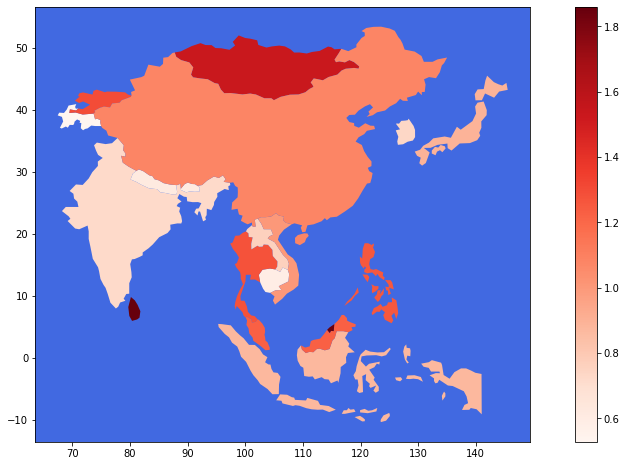

In [29]:
import pandas as pd

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("/content/drive/My Drive/BASE2/GeoData/WorldDevelopmentIndicators/Indicators.csv")

# Gross enrolment ratio, tertiary, gender parity index (GPI) を取り出す
data = indicators[indicators['IndicatorCode'] == 'SE.ENR.TERT.FM.ZS']

# 2010年のデータのみに絞り込む
data = data[data['Year'] == 2010]

# 予め国コードを修正
# data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

###############################################
# アジアのみを取り出したい！

# アジアに分類される国の情報を取得
asia = pd.read_csv('/content/drive/My Drive/BASE2/GeoData/Asia.csv')

# アジアの国コード
asia_iso_a3 = asia['alpha-3']

# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
asia_data = data.copy() # データのコピー
asia_data = asia_data[data['CountryCode'].isin(asia_iso_a3)] # データの絞り込み

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 後のマージのため，列名 CountryCode を iso_a3 へリネーム
asia_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

# 国コードをキーとしてマージする
wv = world.merge(asia_data, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.set_facecolor('royalblue') # 背景色の設定
wv.plot(ax=ax, column='Value', cmap='Reds', legend=True)

### 考察
- 日本(Japan)は 1.0 をやや下回る。
- バランスが取れているのは中国(China)，ベトナム(Vietnam)
- 数値がやや高めに出ているのはタイ(Thailand)，フィリピン(Philippines)，マレーシア(Malaysia)

In [33]:
asia_data[['CountryName', 'Value']].sort_values('Value', ascending=False)

,CountryName,Value
4997855,Sri Lanka,1.85985
4883563,Brunei Darussalam,1.84741
4962331,Mongolia,1.53514
4942846,Kyrgyz Republic,1.30032
5007845,Thailand,1.27800
4980189,Philippines,1.25654
4954109,Malaysia,1.22995
4893581,China,1.08229
5022327,Vietnam,1.00393
4927096,"Hong Kong SAR, China",0.98750


# 課題
アフリカ諸国を対象として
1. 初等・中等・高等教育の就学率を調べよ。
1. gender parity index (GPI) を調べよ。

いずれも可視化した上で，考察すること。

# 課題(の解答)：アフリカ諸国における教育の現状

<AxesSubplot:title={'center':'tertiary'}>

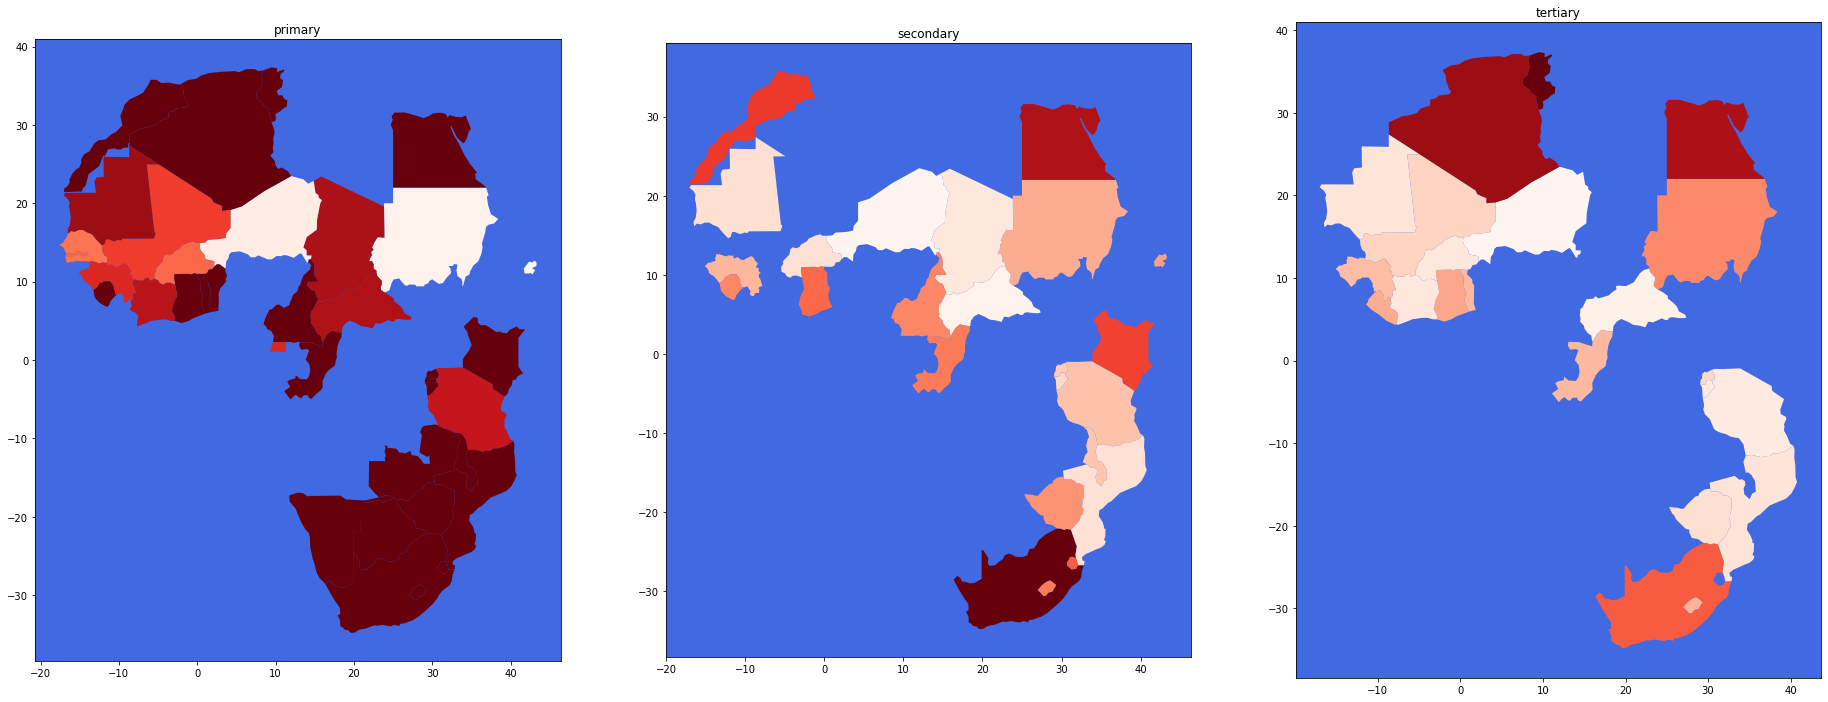

In [ ]:
import pandas as pd

def extract(data, country_iso_a3, year=2012):
    data = data[data['Year'] == year]
    data = data[data['CountryCode'].isin(country_iso_a3)]

    # 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
    extracted_data = data.copy() # データフレームのコピー
    mask = data['Value'] > 100 # データ書き換え対象を絞り込むための条件式
    extracted_data.loc[mask, 'Value'] = 100 # 値の置き換え

    # 予め国コードを修正 (アフリカ特有の処理)
    extracted_data.replace({'CountryCode':{'ZAR':'COD'}}, inplace=True)

    # 後のマージのため，列名 CountryCode を iso_a3 へリネーム
    extracted_data.rename({'CountryCode':'iso_a3'}, axis=1, inplace=True)

    return extracted_data

# World Development Indicators のデータを読み込む
indicators = pd.read_csv("WorldDevelopmentIndicators/Indicators.csv")

# Access to electricity (% of population) を取り出す
primary = indicators[indicators['IndicatorCode'] == 'SE.PRM.ENRR']
secondary = indicators[indicators['IndicatorCode'] == 'SE.SEC.ENRR']
tertiary = indicators[indicators['IndicatorCode'] == 'SE.TER.ENRR']

###############################################
# アフリカのみを取り出したい！

# アフリカに分類される国の情報を取得
africa = pd.read_csv('Africa.csv')

# アフリカの国コード
africa_iso_a3 = africa['alpha-3']

# 2012年のデータのみに絞り込む
# CountryCode が「アジア諸国の国コードのリスト」に含まれるデータのみ取り出す
# 就学率は 100% をこえるものだ，という説明に基づき，100 を越えた場合は 100% とみなす。
primary = extract(primary, africa_iso_a3, year=2012)
secondary = extract(secondary, africa_iso_a3, year=2012)
tertiary = extract(tertiary, africa_iso_a3, year=2012)

###############################################
# geopandas の提供する naturalearth_lowres データセットに上記の値を被せたい

import geopandas

dataset = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(dataset)

# 国コードをキーとしてマージする
merged_primary = world.merge(primary, how='inner', on='iso_a3', copy=True)
merged_secondary = world.merge(secondary, how='inner', on='iso_a3', copy=True)
merged_tertiary = world.merge(tertiary, how='inner', on='iso_a3', copy=True)

###############################################
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'royalblue' # 背景色の設定 (複数の図に一斉に設定するパターン)

fig, ax = plt.subplots(1, 3, figsize=(32, 16)) # 1行 3列
ax[0].set_title("primary")
ax[1].set_title("secondary")
ax[2].set_title("tertiary")
merged_primary.plot(ax=ax[0], column='Value', cmap='Reds') #, legend=True)
merged_secondary.plot(ax=ax[1], column='Value', cmap='Reds') #, legend=True)
merged_tertiary.plot(ax=ax[2], column='Value', cmap='Reds') #, legend=True)